In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torch.nn.functional as F

import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

epochs = 10
batch_size = 16
lr = 1e-3
lr_decay = 1e-7

train_dir = "carla-dataset/train/images"
annotation_dir = "carla-dataset/train/annotations/"

In [2]:
class CarlaDataset(Dataset):
    
    def __init__(self, root_dir, annotation_dir, resize=(128,128), transform=None):
        
        """
        @param:
            root_dir (str): path of the input images from the CARLA simulator
            annotation_dir (str): path of the input annotation images
            resize(tup): pass in a tuple of the new image + annotation input sizes   
            transform(torvision.transforms): input a torchvision.transforms attribute to the class for further data preprocessing.
            
        """
        
        self.root_dir = root_dir
        self.annotation_dir = annotation_dir
        self.resize = resize
        self.dataset = []
        
        for (img_name,annotation_name) in zip(os.listdir(self.root_dir),os.listdir(self.annotation_dir)):
            self.dataset.append([os.path.join(root_dir,img_name),os.path.join(annotation_dir,annotation_name)])

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        img, annotation = self.dataset[idx]
        img = cv2.imread(img)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img,self.resize)
        img = img/255.0
        img = img.astype(np.float32)
        img = np.expand_dims(img, axis=0)
        
        annotation = cv2.imread(annotation,0)
        annotation = cv2.resize(annotation,self.resize)
        annotation = annotation.astype(np.float32)
        annotation = np.expand_dims(annotation, axis=0)
        annotation[annotation!=0] = 1 #classify both lanes as only 1 class

        img = torch.from_numpy(img)
        annotation = torch.from_numpy(annotation) 
        
        return img, annotation

In [3]:
carla_dataset = CarlaDataset(train_dir,annotation_dir,resize=(128,128))
data_loader = DataLoader(carla_dataset, batch_size=batch_size, shuffle=True)
img, annot = next(iter(data_loader))
print(f"dataset length: {len(carla_dataset)} \nimg shape: {img.shape}, annotations shape: {annot.shape}")

dataset length: 2922 
img shape: torch.Size([16, 1, 128, 128]), annotations shape: torch.Size([16, 1, 128, 128])


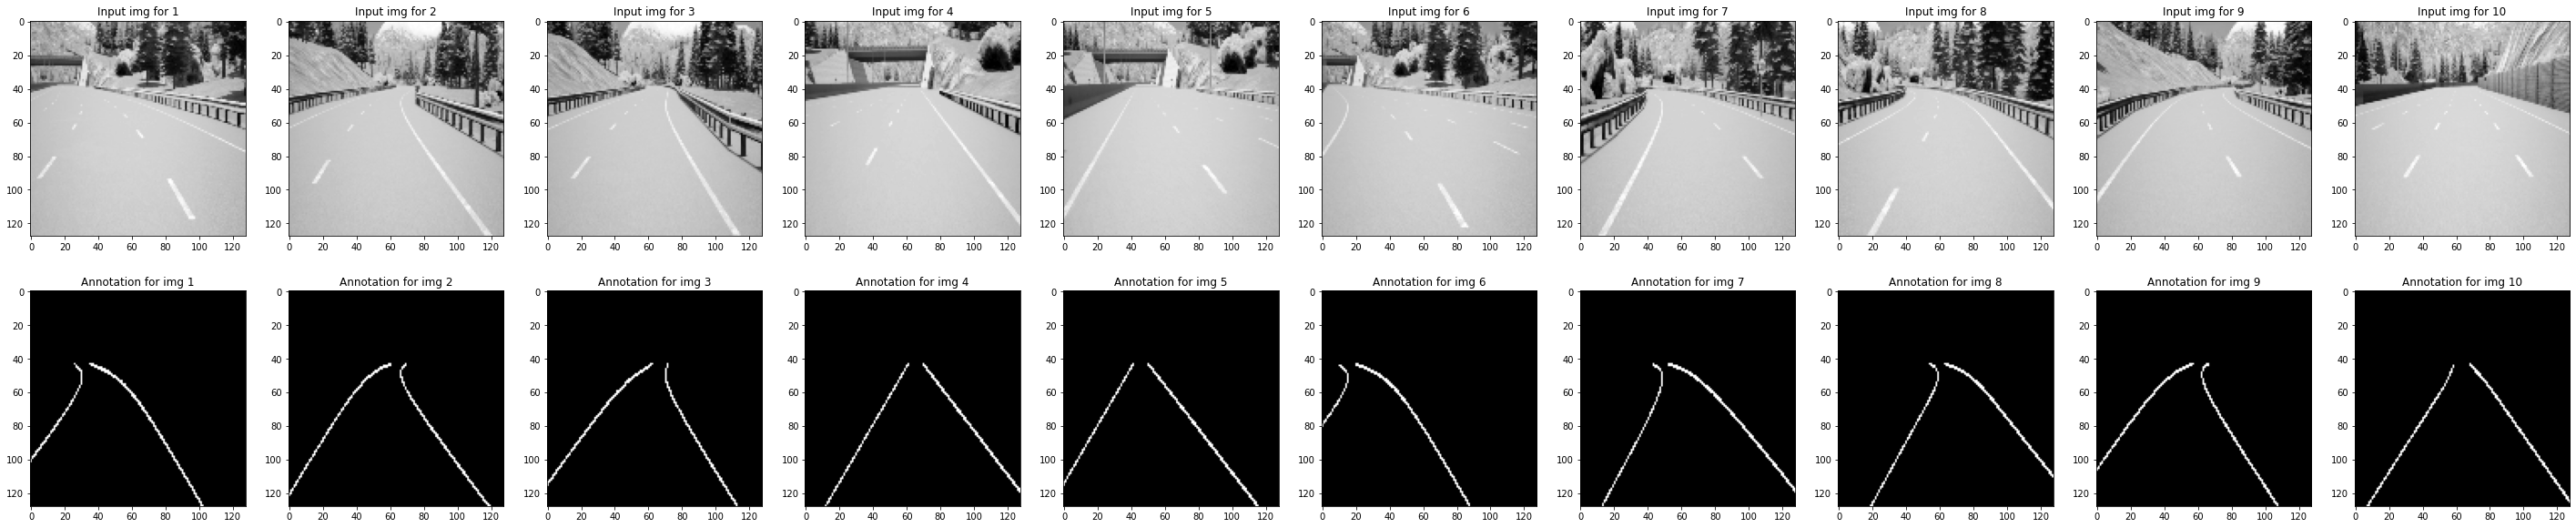

In [4]:
plt.figure(figsize=(50, 10))
for j in range(10):
    if j >= 10: break
    image = np.squeeze(img[j].cpu().numpy())
    plt.subplot(2, 10, j+1)
    plt.title(f"Input img for {j+1}")
    plt.imshow(image,cmap="gray")

for k in range(10):
    if k >= 10: break
    annotation = np.squeeze(annot[k].cpu().numpy())
    plt.subplot(2, 10, 10+k+1)
    plt.title(f"Annotation for img {k+1}")
    plt.imshow(annotation,cmap="gray")

In [5]:
class SegNet_Model(nn.Module):
    
    def __init__(self, in_channels, out_channels, padding, affine, track_running_stats):
        
        """
        Implementation of, "SegNet: A Deep Convolutional Encoder-Decoder Architecture for Image Segmentation" (Badrinarayanan et al., 2017)
        https://arxiv.org/pdf/1511.00561.pdf
        
        @param:
            in_channels (int): specify the number of input channels for the image
            out_channels (int): specify the number of output channels to be released from the U-Net model
            padding (bool): specify if padding is to be (or not) used in the U-Net implementation
            dropout (bool): specify if dropout is to be (or not) used in the U-Net implementation
            affine (bool): specify if the U-Net model should have learnable affine parameters
            track_running_stats (bool): specify if the U-Net model should be tracking the mean and variance
            
        @note:
            The paper, "Normalization in Training U-Net for 2D Biomedical Semantic Segmentation" (Zhou et al., 2018)  states that the
            use of Instance Normalization can create higher accuracy than other state-of-the-art methods such as Batch Normalization and
            Layer Normalization to help combat the epxloding gradients problem in U-Net network systems.
            
            I choose to use Instance Normalization (IN) after every time ReLU is applied on top of a convolution instead of the typical BN
            in the proposed SegNet model. This will now allow for proper normalization to occur throughout training. I also choose to set 
            the IN to have learnable affine parameters and allow it to track the running mean and variance instead of choosing to use 
            batch statistics for training and evaluation modes.
        """

        super(SegNet_Model, self).__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.padding = 1 if padding else 0
        
        self.relu = nn.ReLU()
        
        self.conv1_1 = nn.Conv2d(in_channels, 64, 3, stride=1, padding=padding)
        self.conv1_2 = nn.Conv2d(64, 64, 3, stride=1, padding=padding)
        
        self.conv2_1 = nn.Conv2d(64, 128, 3, stride=1, padding=padding)
        self.conv2_2 = nn.Conv2d(128, 128, 3, stride=1, padding=padding)
        
        self.conv3_1 = nn.Conv2d(128, 256, 3, stride=1, padding=padding)
        self.conv3_2 = nn.Conv2d(256, 256, 3, stride=1, padding=padding)
        self.conv3_3 = nn.Conv2d(256, 256, 3, stride=1, padding=padding)
        
        self.conv4_1 = nn.Conv2d(256, 512, 3, stride=1, padding=padding)
        self.conv4_2 = nn.Conv2d(512, 512, 3, stride=1, padding=padding)
        self.conv4_3 = nn.Conv2d(512, 512, 3, stride=1, padding=padding)
        
        self.conv5_1 = nn.Conv2d(512, 512, 3, stride=1, padding=padding)
        self.conv5_2 = nn.Conv2d(512, 512, 3, stride=1, padding=padding)
        self.conv5_3 = nn.Conv2d(512, 512, 3, stride=1, padding=padding)
        
        self.deconv5_3 = nn.Conv2d(512, 512, 3, stride=1, padding=padding)
        self.deconv5_2 = nn.Conv2d(512, 512, 3, stride=1, padding=padding)
        self.deconv5_1 = nn.Conv2d(512, 512, 3, stride=1, padding=padding)
        
        self.deconv4_3 = nn.Conv2d(512, 512, 3, stride=1, padding=padding)
        self.deconv4_2 = nn.Conv2d(512, 512, 3, stride=1, padding=padding)
        self.deconv4_1 = nn.Conv2d(512, 256, 3, stride=1, padding=padding)
        
        self.deconv3_3 = nn.Conv2d(256, 256, 3, stride=1, padding=padding)
        self.deconv3_2 = nn.Conv2d(256, 256, 3, stride=1, padding=padding)
        self.deconv3_1 = nn.Conv2d(256, 128, 3, stride=1, padding=padding)

        self.deconv2_2 = nn.Conv2d(128, 128, 3, stride=1, padding=padding)
        self.deconv2_1 = nn.Conv2d(128, 64, 3, stride=1, padding=padding)

        self.deconv1_2 = nn.Conv2d(64, 64, 3, stride=1, padding=padding)
        self.deconv1_1 = nn.Conv2d(64, out_channels, 3, stride=1, padding=padding)
        
        self.in_64 = nn.InstanceNorm2d(64,affine=affine,track_running_stats=track_running_stats)
        self.in_128 = nn.InstanceNorm2d(128,affine=affine,track_running_stats=track_running_stats)
        self.in_256 = nn.InstanceNorm2d(256,affine=affine,track_running_stats=track_running_stats)
        self.in_512 = nn.InstanceNorm2d(512,affine=affine,track_running_stats=track_running_stats)
        
    def forward(self, x):
        
        conv1_1 = self.in_64(self.relu(self.conv1_1(x)))
        conv1_2 = self.in_64(self.relu(self.conv1_2(conv1_1)))
        pool_1, id1 = F.max_pool2d(conv1_2,kernel_size=2,stride=2,return_indices=True)
        
        conv2_1 = self.in_128(self.relu(self.conv2_1(pool_1)))
        conv2_2 = self.in_128(self.relu(self.conv2_2(conv2_1)))
        pool_2, id2 = F.max_pool2d(conv2_2,kernel_size=2,stride=2,return_indices=True)
        
        conv3_1 = self.in_256(self.relu(self.conv3_1(pool_2)))
        conv3_2 = self.in_256(self.relu(self.conv3_2(conv3_1)))
        conv3_3 = self.in_256(self.relu(self.conv3_3(conv3_2)))
        pool_3, id3 = F.max_pool2d(conv3_3,kernel_size=2,stride=2,return_indices=True)
        
        conv4_1 = self.in_512(self.relu(self.conv4_1(pool_3)))
        conv4_2 = self.in_512(self.relu(self.conv4_2(conv4_1)))
        conv4_3 = self.in_512(self.relu(self.conv4_3(conv4_2)))
        pool_4, id4 = F.max_pool2d(conv4_3,kernel_size=2,stride=2,return_indices=True)
        
        conv5_1 = self.in_512(self.relu(self.conv5_1(pool_4)))
        conv5_2 = self.in_512(self.relu(self.conv5_2(conv5_1)))
        conv5_3 = self.in_512(self.relu(self.conv5_3(conv5_2)))
        pool_5, id5 = F.max_pool2d(conv5_3,kernel_size=2,stride=2,return_indices=True)
        
        unpool_5 = F.max_unpool2d(pool_5,id5,kernel_size=2,stride=2)
        deconv5_3 = self.in_512(self.relu(self.deconv5_3(unpool_5)))
        deconv5_2 = self.in_512(self.relu(self.deconv5_2(deconv5_3)))
        deconv5_1 = self.in_512(self.relu(self.deconv5_1(deconv5_2)))
        
        unpool_4 = F.max_unpool2d(deconv5_1,id4,kernel_size=2,stride=2)
        deconv4_3 = self.in_512(self.relu(self.deconv4_3(unpool_4)))
        deconv4_2 = self.in_512(self.relu(self.deconv4_2(deconv4_3)))
        deconv4_1 = self.in_256(self.relu(self.deconv4_1(deconv4_2)))
        
        unpool_3 = F.max_unpool2d(deconv4_1,id3,kernel_size=2,stride=2)
        deconv3_3 = self.in_256(self.relu(self.deconv3_3(unpool_3)))
        deconv3_2 = self.in_256(self.relu(self.deconv3_2(deconv3_3)))
        deconv3_1 = self.in_128(self.relu(self.deconv3_1(deconv3_2)))
        
        unpool_2 = F.max_unpool2d(deconv3_1,id2,kernel_size=2,stride=2)
        deconv2_2 = self.in_128(self.relu(self.deconv2_2(unpool_2)))
        deconv2_1 = self.in_64(self.relu(self.deconv2_1(deconv2_2)))
        
        unpool_1 = F.max_unpool2d(deconv2_1,id1,kernel_size=2,stride=2)
        deconv1_2 = self.in_64(self.relu(self.deconv1_2(unpool_1)))
        output = self.deconv1_1(deconv1_2)
        
        output = torch.sigmoid(output)
        return output

In [6]:
model = SegNet_Model(in_channels=1,out_channels=1,padding=True,affine=True,track_running_stats=True).to(device)
summary(model,(1,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]             640
              ReLU-2         [-1, 64, 128, 128]               0
    InstanceNorm2d-3         [-1, 64, 128, 128]             128
            Conv2d-4         [-1, 64, 128, 128]          36,928
              ReLU-5         [-1, 64, 128, 128]               0
    InstanceNorm2d-6         [-1, 64, 128, 128]             128
            Conv2d-7          [-1, 128, 64, 64]          73,856
              ReLU-8          [-1, 128, 64, 64]               0
    InstanceNorm2d-9          [-1, 128, 64, 64]             256
           Conv2d-10          [-1, 128, 64, 64]         147,584
             ReLU-11          [-1, 128, 64, 64]               0
   InstanceNorm2d-12          [-1, 128, 64, 64]             256
           Conv2d-13          [-1, 256, 32, 32]         295,168
             ReLU-14          [-1, 256,

In [7]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice
    
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return 1 - IoU

In [8]:
outputs = []

criterion = IoULoss()
opt = torch.optim.Adam(model.parameters(),lr=lr)

steps_per_epoch = len(carla_dataset) // batch_size


for epoch in range(epochs):
    print('-'*20)
    for i, (img, annotation) in enumerate(data_loader):
        
        img = img.to(device)
        annotation = annotation.to(device)
        
        output = model(img)
        loss = criterion(output, annotation)
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        if (int(i+1))%(steps_per_epoch//5) == 0:
            print(f"epoch {epoch+1}/{epochs}, step {i+1}/{steps_per_epoch}, IoU score = {1-loss.item():.4f}")
            
    outputs.append((img, annotation, output))

--------------------
epoch 1/10, step 36/182, IoU score = 0.1308
epoch 1/10, step 72/182, IoU score = 0.3034
epoch 1/10, step 108/182, IoU score = 0.5377
epoch 1/10, step 144/182, IoU score = 0.5278
epoch 1/10, step 180/182, IoU score = 0.4882
--------------------
epoch 2/10, step 36/182, IoU score = 0.5859
epoch 2/10, step 72/182, IoU score = 0.6037
epoch 2/10, step 108/182, IoU score = 0.5668
epoch 2/10, step 144/182, IoU score = 0.6572
epoch 2/10, step 180/182, IoU score = 0.6309
--------------------
epoch 3/10, step 36/182, IoU score = 0.6233
epoch 3/10, step 72/182, IoU score = 0.6711
epoch 3/10, step 108/182, IoU score = 0.6230
epoch 3/10, step 144/182, IoU score = 0.6350
epoch 3/10, step 180/182, IoU score = 0.6793
--------------------
epoch 4/10, step 36/182, IoU score = 0.6378
epoch 4/10, step 72/182, IoU score = 0.7199
epoch 4/10, step 108/182, IoU score = 0.7008
epoch 4/10, step 144/182, IoU score = 0.6786
epoch 4/10, step 180/182, IoU score = 0.6868
--------------------
epo

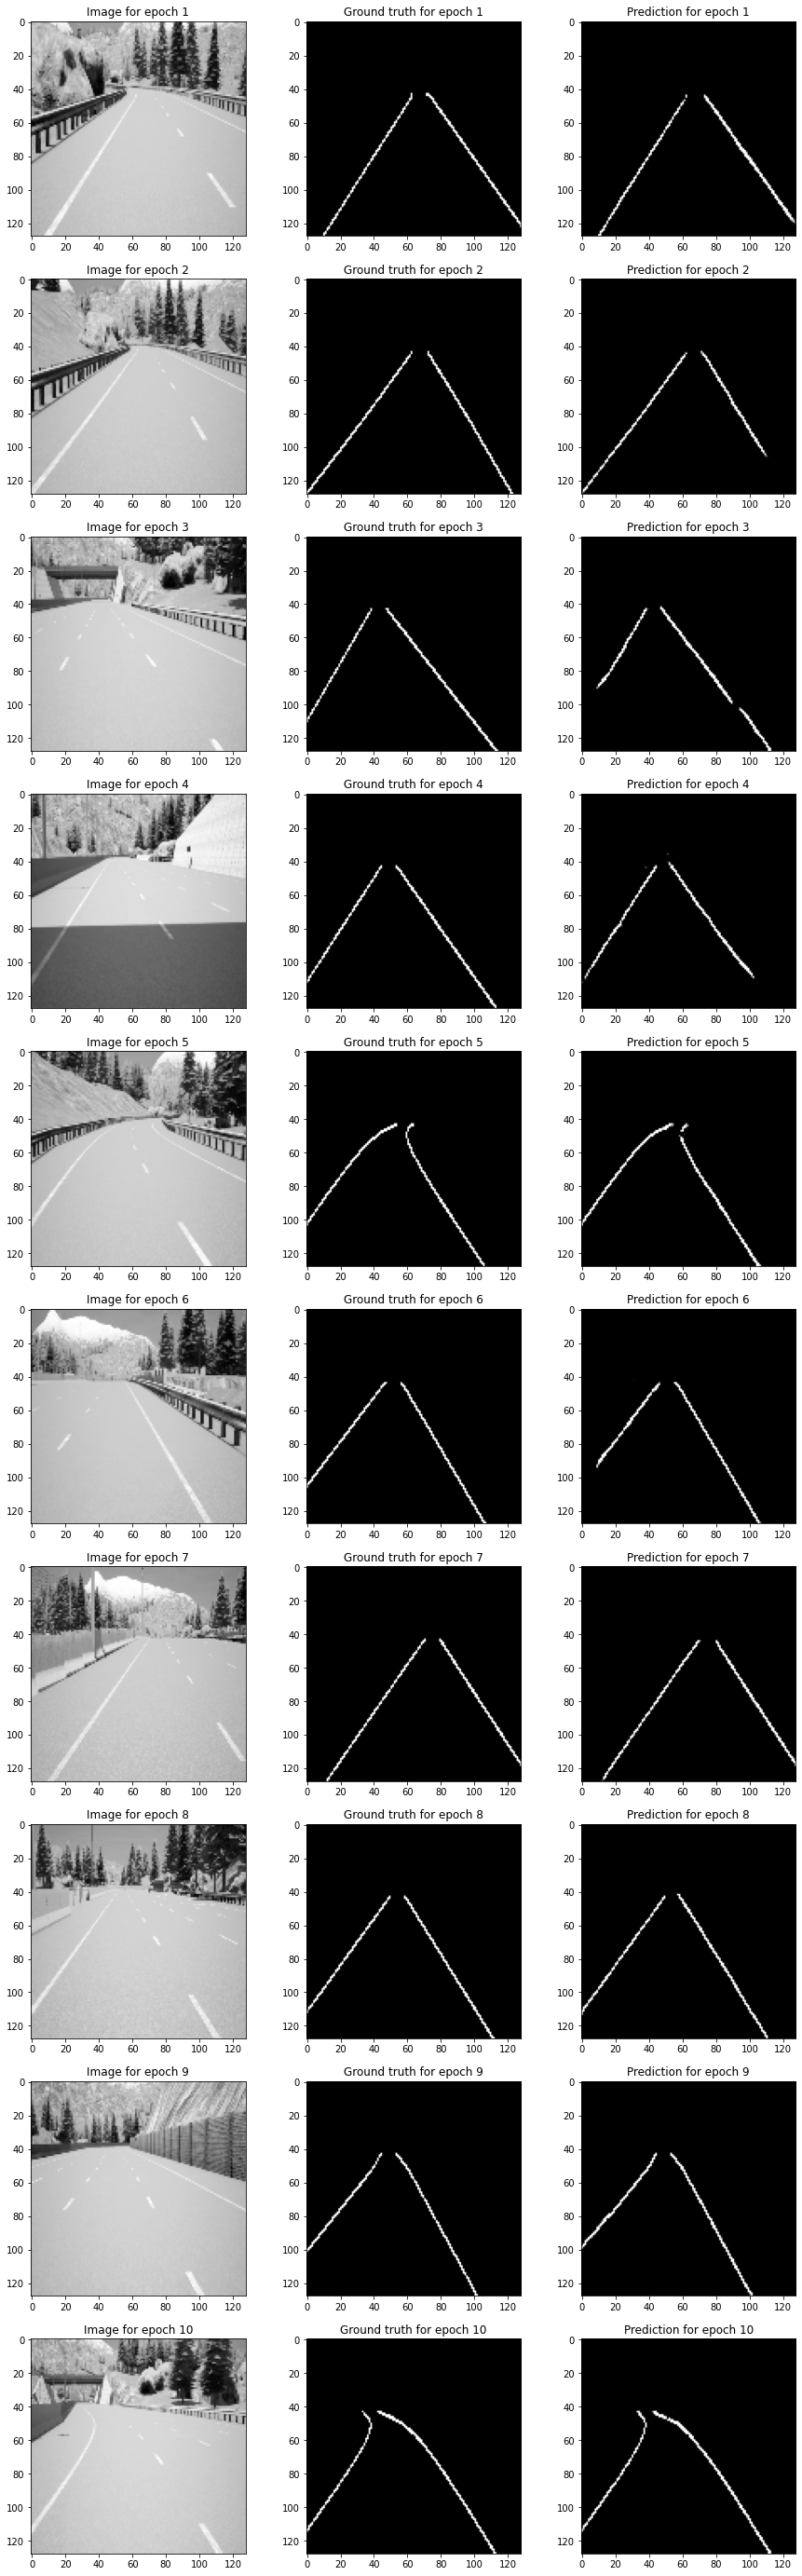

In [9]:
plt.figure(figsize=(15, 50))
for i in range(epochs):   
    image = np.squeeze(outputs[i][0][0].detach().cpu().numpy())
    ground_truth = np.squeeze(outputs[i][1][0].detach().cpu().numpy())
    prediction = np.squeeze(outputs[i][2][0].detach().cpu().numpy())
    i += 1
    plt.subplot(epochs, 3, 3*i-2)
    plt.title(f"Image for epoch {i}")
    plt.imshow(image,cmap="gray")
    plt.subplot(epochs, 3, 3*i-1)
    plt.title(f"Ground truth for epoch {i}")
    plt.imshow(ground_truth,cmap="gray")
    plt.subplot(epochs, 3, 3*i)
    plt.title(f"Prediction for epoch {i}")
    plt.imshow(prediction,cmap="gray")
plt.show()

In [10]:
PATH = "segnet_model.pth"
torch.save(model.state_dict(), PATH) 
print("Model saved")

Model saved
